### Setting
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import pickle
from IPython.display import HTML, display
from torchvision.datasets import ImageFolder
import torch.optim as optim
from statistics import mean
import copy

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
class ProgressMonitor(object):

    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Load the datasets
---

In [7]:
# 압축 풀기
import zipfile

fantasy_zip = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/인이활/project B/images(시도 2).zip')
fantasy_zip.extractall('/content/drive/MyDrive/Colab Notebooks/인이활/project B/images(시도 2)')
fantasy_zip.close()

### 시도 2
---


In [11]:
from torchvision.datasets import ImageFolder

data_dir = "/content/drive/MyDrive/Colab Notebooks/인이활/project B/images(시도 2)"

size = 64

transform = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size, padding=8),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(root=data_dir, transform=transform)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

### 모델
---

In [12]:
class CNN_CPCPCCPFF(nn.Module):

    def __init__(self, channel1=32, channel2=64, channel3=128, fc1=256, fc2=128):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel3, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),

            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.fc_layers = nn.Sequential(

            nn.Linear( 8*8*channel3, fc1 ),
            nn.BatchNorm1d(fc1),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc1, fc2),
            nn.BatchNorm1d(fc2),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc2, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view( x.size(0), -1 )
        x = self.fc_layers(x)
        return x

In [13]:
class CNN_CCPCCPCCPFF(nn.Module):

    def __init__(self, channel1=32, channel2=64, channel3=128, fc1=256, fc2=128):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel1, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel2, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel3, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.fc_layers = nn.Sequential(

            nn.Linear( 8*8*channel3, fc1 ),
            nn.BatchNorm1d(fc1),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc1, fc2),
            nn.BatchNorm1d(fc2),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc2, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view( x.size(0), -1 )
        x = self.fc_layers(x)
        return x

In [14]:
batch_size = 32
learning_rate = 0.001
num_epochs = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

테스트 모델


In [15]:
model = CNN_CPCPCCPFF()

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)

In [16]:
def train(optimizer, model, num_epochs=10, first_epoch=1, scheduler=lr_scheduler):

    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    best_model = copy.deepcopy(model)
    best_acc = 0.0

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)
        model.train()
        progress = ProgressMonitor(length=len(train_set))
        correct_train = 0
        batch_losses = []

        for batch, targets in train_loader:
            batch = batch.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)
            progress.update(batch.shape[0], mean(batch_losses) )

        train_losses.append( mean(batch_losses))

        if scheduler:
            scheduler.step()

        model.eval()
        y_pred = []
        correct_test = 0

        with torch.no_grad():
            for batch, targets in test_loader:
                batch = batch.to(device)
                targets = targets.to(device)
                outputs = model(batch)
                loss = criterion(outputs, targets)
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)

        train_acc = correct_train.item() / len(train_set)
        test_acc = correct_test.item() / len(test_set)

        acc = test_acc

        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))
    model = copy.deepcopy(best_model)
    print('Best test accuracy: {:4f}'.format(best_acc))
    return train_losses, test_losses, y_pred

In [17]:
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 2.2300 4108 / 4108,4108


Training accuracy: 19.23%
Test accuracy: 26.46%

Epoch 2


Loss: 2.0304 4108 / 4108,4108


Training accuracy: 27.51%
Test accuracy: 30.45%

Epoch 3


Loss: 1.9472 4108 / 4108,4108


Training accuracy: 31.01%
Test accuracy: 34.14%

Epoch 4


Loss: 1.8735 4108 / 4108,4108


Training accuracy: 33.98%
Test accuracy: 29.18%

Epoch 5


Loss: 1.8288 4108 / 4108,4108


Training accuracy: 35.74%
Test accuracy: 38.62%

Epoch 6


Loss: 1.7971 4108 / 4108,4108


Training accuracy: 38.19%
Test accuracy: 35.31%

Epoch 7


Loss: 1.7576 4108 / 4108,4108


Training accuracy: 40.19%
Test accuracy: 38.04%

Epoch 8


Loss: 1.7214 4108 / 4108,4108


Training accuracy: 40.56%
Test accuracy: 40.76%

Epoch 9


Loss: 1.6575 4108 / 4108,4108


Training accuracy: 43.18%
Test accuracy: 39.11%

Epoch 10


Loss: 1.6525 4108 / 4108,4108


Training accuracy: 42.62%
Test accuracy: 42.32%

Epoch 11


Loss: 1.5912 4108 / 4108,4108


Training accuracy: 45.30%
Test accuracy: 46.21%

Epoch 12


Loss: 1.5435 4108 / 4108,4108


Training accuracy: 47.74%
Test accuracy: 42.90%

Epoch 13


Loss: 1.5328 4108 / 4108,4108


Training accuracy: 48.93%
Test accuracy: 47.08%

Epoch 14


Loss: 1.4988 4108 / 4108,4108


Training accuracy: 49.66%
Test accuracy: 47.08%

Epoch 15


Loss: 1.4834 4108 / 4108,4108


Training accuracy: 50.44%
Test accuracy: 48.83%

Epoch 16


Loss: 1.4820 4108 / 4108,4108


Training accuracy: 50.00%
Test accuracy: 49.81%

Epoch 17


Loss: 1.4645 4108 / 4108,4108


Training accuracy: 50.97%
Test accuracy: 49.12%

Epoch 18


Loss: 1.4554 4108 / 4108,4108


Training accuracy: 50.32%
Test accuracy: 50.97%

Epoch 19


Loss: 1.4247 4108 / 4108,4108


Training accuracy: 52.85%
Test accuracy: 52.24%

Epoch 20


Loss: 1.4208 4108 / 4108,4108


Training accuracy: 52.60%
Test accuracy: 53.02%

Epoch 21


Loss: 1.3707 4108 / 4108,4108


Training accuracy: 54.77%
Test accuracy: 49.90%

Epoch 22


Loss: 1.3607 4108 / 4108,4108


Training accuracy: 54.75%
Test accuracy: 51.17%

Epoch 23


Loss: 1.3443 4108 / 4108,4108


Training accuracy: 55.26%
Test accuracy: 50.68%

Epoch 24


Loss: 1.3500 4108 / 4108,4108


Training accuracy: 55.31%
Test accuracy: 50.49%

Epoch 25


Loss: 1.3313 4108 / 4108,4108


Training accuracy: 55.53%
Test accuracy: 54.28%

Epoch 26


Loss: 1.3223 4108 / 4108,4108


Training accuracy: 56.86%
Test accuracy: 52.33%

Epoch 27


Loss: 1.3169 4108 / 4108,4108


Training accuracy: 56.38%
Test accuracy: 49.22%

Epoch 28


Loss: 1.3009 4108 / 4108,4108


Training accuracy: 57.01%
Test accuracy: 54.67%

Epoch 29


Loss: 1.2960 4108 / 4108,4108


Training accuracy: 56.84%
Test accuracy: 54.28%

Epoch 30


Loss: 1.3020 4108 / 4108,4108


Training accuracy: 56.91%
Test accuracy: 51.56%

Epoch 31


Loss: 1.2777 4108 / 4108,4108


Training accuracy: 57.69%
Test accuracy: 53.79%

Epoch 32


Loss: 1.2853 4108 / 4108,4108


Training accuracy: 57.33%
Test accuracy: 53.70%

Epoch 33


Loss: 1.2622 4108 / 4108,4108


Training accuracy: 58.47%
Test accuracy: 52.82%

Epoch 34


Loss: 1.2633 4108 / 4108,4108


Training accuracy: 59.08%
Test accuracy: 52.43%

Epoch 35


Loss: 1.2549 4108 / 4108,4108


Training accuracy: 59.42%
Test accuracy: 53.31%

Epoch 36


Loss: 1.2610 4108 / 4108,4108


Training accuracy: 58.37%
Test accuracy: 53.11%

Epoch 37


Loss: 1.2516 4108 / 4108,4108


Training accuracy: 59.47%
Test accuracy: 54.18%

Epoch 38


Loss: 1.2370 4108 / 4108,4108


Training accuracy: 59.62%
Test accuracy: 53.79%

Epoch 39


Loss: 1.2513 4108 / 4108,4108


Training accuracy: 58.54%
Test accuracy: 53.70%

Epoch 40


Loss: 1.2596 4108 / 4108,4108


Training accuracy: 58.33%
Test accuracy: 53.60%

Epoch 41


Loss: 1.2394 4108 / 4108,4108


Training accuracy: 58.86%
Test accuracy: 52.82%

Epoch 42


Loss: 1.2575 4108 / 4108,4108


Training accuracy: 57.77%
Test accuracy: 54.77%

Epoch 43


Loss: 1.2409 4108 / 4108,4108


Training accuracy: 58.74%
Test accuracy: 53.31%

Epoch 44


Loss: 1.2505 4108 / 4108,4108


Training accuracy: 59.30%
Test accuracy: 52.72%

Epoch 45


Loss: 1.2420 4108 / 4108,4108


Training accuracy: 58.71%
Test accuracy: 54.28%

Epoch 46


Loss: 1.2300 4108 / 4108,4108


Training accuracy: 60.32%
Test accuracy: 53.31%

Epoch 47


Loss: 1.2384 4108 / 4108,4108


Training accuracy: 59.52%
Test accuracy: 54.57%

Epoch 48


Loss: 1.2249 4108 / 4108,4108


Training accuracy: 61.15%
Test accuracy: 53.70%

Epoch 49


Loss: 1.2418 4108 / 4108,4108


Training accuracy: 59.49%
Test accuracy: 52.92%

Epoch 50


Loss: 1.2179 4108 / 4108,4108


Training accuracy: 60.32%
Test accuracy: 54.77%

Epoch 51


Loss: 1.2487 4108 / 4108,4108


Training accuracy: 58.30%
Test accuracy: 52.04%

Epoch 52


Loss: 1.2370 4108 / 4108,4108


Training accuracy: 59.86%
Test accuracy: 55.06%

Epoch 53


Loss: 1.2361 4108 / 4108,4108


Training accuracy: 58.67%
Test accuracy: 52.63%

Epoch 54


Loss: 1.2127 4108 / 4108,4108


Training accuracy: 60.18%
Test accuracy: 53.60%

Epoch 55


Loss: 1.2167 4108 / 4108,4108


Training accuracy: 60.93%
Test accuracy: 54.96%

Epoch 56


Loss: 1.2278 4108 / 4108,4108


Training accuracy: 59.25%
Test accuracy: 52.72%

Epoch 57


Loss: 1.2287 4108 / 4108,4108


Training accuracy: 59.93%
Test accuracy: 51.56%

Epoch 58


Loss: 1.2167 4108 / 4108,4108


Training accuracy: 60.03%
Test accuracy: 52.92%

Epoch 59


Loss: 1.2206 4108 / 4108,4108


Training accuracy: 59.98%
Test accuracy: 54.77%

Epoch 60


Loss: 1.2262 4108 / 4108,4108


Training accuracy: 60.35%
Test accuracy: 54.38%

Epoch 61


Loss: 1.2132 4108 / 4108,4108


Training accuracy: 60.54%
Test accuracy: 52.92%

Epoch 62


Loss: 1.2235 4108 / 4108,4108


Training accuracy: 59.83%
Test accuracy: 54.47%

Epoch 63


Loss: 1.2295 4108 / 4108,4108


Training accuracy: 59.66%
Test accuracy: 55.45%

Epoch 64


Loss: 1.2289 4108 / 4108,4108


Training accuracy: 59.71%
Test accuracy: 54.18%

Epoch 65


Loss: 1.2173 4108 / 4108,4108


Training accuracy: 59.62%
Test accuracy: 54.38%

Epoch 66


Loss: 1.2223 4108 / 4108,4108


Training accuracy: 60.08%
Test accuracy: 54.18%

Epoch 67


Loss: 1.2236 4108 / 4108,4108


Training accuracy: 60.10%
Test accuracy: 54.09%

Epoch 68


Loss: 1.2138 4108 / 4108,4108


Training accuracy: 61.15%
Test accuracy: 53.70%

Epoch 69


Loss: 1.2303 4108 / 4108,4108


Training accuracy: 59.49%
Test accuracy: 53.79%

Epoch 70


Loss: 1.2425 4108 / 4108,4108


Training accuracy: 59.30%
Test accuracy: 53.40%

Epoch 71


Loss: 1.2185 4108 / 4108,4108


Training accuracy: 59.86%
Test accuracy: 53.89%

Epoch 72


Loss: 1.2135 4108 / 4108,4108


Training accuracy: 60.30%
Test accuracy: 54.28%

Epoch 73


Loss: 1.2357 4108 / 4108,4108


Training accuracy: 59.54%
Test accuracy: 54.77%

Epoch 74


Loss: 1.2220 4108 / 4108,4108


Training accuracy: 60.22%
Test accuracy: 53.11%

Epoch 75


Loss: 1.2121 4108 / 4108,4108


Training accuracy: 60.59%
Test accuracy: 52.53%

Epoch 76


Loss: 1.2192 4108 / 4108,4108


Training accuracy: 60.32%
Test accuracy: 53.40%

Epoch 77


Loss: 1.2142 4108 / 4108,4108


Training accuracy: 60.44%
Test accuracy: 54.96%

Epoch 78


Loss: 1.2245 4108 / 4108,4108


Training accuracy: 60.66%
Test accuracy: 54.18%

Epoch 79


Loss: 1.2259 4108 / 4108,4108


Training accuracy: 59.83%
Test accuracy: 56.52%

Epoch 80


Loss: 1.2253 4108 / 4108,4108


Training accuracy: 60.08%
Test accuracy: 53.79%

Epoch 81


Loss: 1.2123 4108 / 4108,4108


Training accuracy: 61.25%
Test accuracy: 53.60%

Epoch 82


Loss: 1.2313 4108 / 4108,4108


Training accuracy: 59.66%
Test accuracy: 54.67%

Epoch 83


Loss: 1.2244 4108 / 4108,4108


Training accuracy: 60.35%
Test accuracy: 54.86%

Epoch 84


Loss: 1.2233 4108 / 4108,4108


Training accuracy: 60.49%
Test accuracy: 54.18%

Epoch 85


Loss: 1.2134 4108 / 4108,4108


Training accuracy: 59.83%
Test accuracy: 54.28%

Epoch 86


Loss: 1.2222 4108 / 4108,4108


Training accuracy: 59.69%
Test accuracy: 54.38%

Epoch 87


Loss: 1.2260 4108 / 4108,4108


Training accuracy: 59.74%
Test accuracy: 55.06%

Epoch 88


Loss: 1.2047 4108 / 4108,4108


Training accuracy: 60.47%
Test accuracy: 53.21%

Epoch 89


Loss: 1.2337 4108 / 4108,4108


Training accuracy: 59.01%
Test accuracy: 53.79%

Epoch 90


Loss: 1.2089 4108 / 4108,4108


Training accuracy: 61.00%
Test accuracy: 54.57%

Epoch 91


Loss: 1.2218 4108 / 4108,4108


Training accuracy: 59.96%
Test accuracy: 54.47%

Epoch 92


Loss: 1.2169 4108 / 4108,4108


Training accuracy: 59.62%
Test accuracy: 54.09%

Epoch 93


Loss: 1.2367 4108 / 4108,4108


Training accuracy: 59.62%
Test accuracy: 53.40%

Epoch 94


Loss: 1.2302 4108 / 4108,4108


Training accuracy: 59.81%
Test accuracy: 53.11%

Epoch 95


Loss: 1.2205 4108 / 4108,4108


Training accuracy: 59.98%
Test accuracy: 53.70%

Epoch 96


Loss: 1.2077 4108 / 4108,4108


Training accuracy: 61.17%
Test accuracy: 54.96%

Epoch 97


Loss: 1.2160 4108 / 4108,4108


Training accuracy: 60.56%
Test accuracy: 53.99%

Epoch 98


Loss: 1.2476 4108 / 4108,4108


Training accuracy: 59.15%
Test accuracy: 53.40%

Epoch 99


Loss: 1.2088 4108 / 4108,4108


Training accuracy: 60.03%
Test accuracy: 54.47%

Epoch 100


Loss: 1.2054 4108 / 4108,4108


Training accuracy: 60.49%
Test accuracy: 54.47%

Best test accuracy: 0.565175


모델별 비교

In [18]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [19]:
def train_and_calculate_best_acc(optimizer, model, num_epochs=50, first_epoch=1, scheduler=lr_scheduler):

    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    best_model = copy.deepcopy(model)
    best_acc = 0.0

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)
        model.train()
        progress = ProgressMonitor(length=len(train_set))
        correct_train = 0
        batch_losses = []

        for batch, targets in train_loader:
            batch = batch.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)
            progress.update(batch.shape[0], mean(batch_losses) )

        train_losses.append( mean(batch_losses))

        if scheduler:
            scheduler.step()

        model.eval()
        y_pred = []
        correct_test = 0

        with torch.no_grad():
            for batch, targets in test_loader:
                batch = batch.to(device)
                targets = targets.to(device)
                outputs = model(batch)
                loss = criterion(outputs, targets)
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)

        train_acc = correct_train.item() / len(train_set)
        test_acc = correct_test.item() / len(test_set)

        acc = test_acc

        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))
    model = copy.deepcopy(best_model)
    print('Best test accuracy: {:4f}'.format(best_acc))
    return best_acc

In [20]:
# 너무 오래 걸려서 절반씩 실행

learning_rate = 0.001
channel_set = [[32, 64, 128]]
fc_set = [[256, 128], [512, 256]]
acc_model1 = []
acc_model2 = []
for chnls in channel_set:
    for fcs in fc_set:
        print(chnls, fcs)

        model1 = CNN_CPCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model1.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model1.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model1)
        acc_model1.append(acc)

        model2 = CNN_CCPCCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model2.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model2.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model2)
        acc_model2.append(acc)

acc_model1, acc_model2

[32, 64, 128] [256, 128]
Epoch 1


Loss: 2.2498 4108 / 4108,4108


Training accuracy: 18.74%
Test accuracy: 26.17%

Epoch 2


Loss: 2.0603 4108 / 4108,4108


Training accuracy: 26.61%
Test accuracy: 29.47%

Epoch 3


Loss: 1.9547 4108 / 4108,4108


Training accuracy: 30.57%
Test accuracy: 23.64%

Epoch 4


Loss: 1.8939 4108 / 4108,4108


Training accuracy: 34.93%
Test accuracy: 36.58%

Epoch 5


Loss: 1.8647 4108 / 4108,4108


Training accuracy: 35.30%
Test accuracy: 35.51%

Epoch 6


Loss: 1.8027 4108 / 4108,4108


Training accuracy: 37.49%
Test accuracy: 37.94%

Epoch 7


Loss: 1.7473 4108 / 4108,4108


Training accuracy: 38.70%
Test accuracy: 40.37%

Epoch 8


Loss: 1.7263 4108 / 4108,4108


Training accuracy: 40.26%
Test accuracy: 36.48%

Epoch 9


Loss: 1.6957 4108 / 4108,4108


Training accuracy: 41.67%
Test accuracy: 40.47%

Epoch 10


Loss: 1.6666 4108 / 4108,4108


Training accuracy: 42.99%
Test accuracy: 41.54%

Epoch 11


Loss: 1.6329 4108 / 4108,4108


Training accuracy: 43.45%
Test accuracy: 41.83%

Epoch 12


Loss: 1.6051 4108 / 4108,4108


Training accuracy: 44.79%
Test accuracy: 43.77%

Epoch 13


Loss: 1.5609 4108 / 4108,4108


Training accuracy: 46.67%
Test accuracy: 46.11%

Epoch 14


Loss: 1.5603 4108 / 4108,4108


Training accuracy: 46.20%
Test accuracy: 44.36%

Epoch 15


Loss: 1.5275 4108 / 4108,4108


Training accuracy: 47.74%
Test accuracy: 45.62%

Epoch 16


Loss: 1.5147 4108 / 4108,4108


Training accuracy: 48.37%
Test accuracy: 47.47%

Epoch 17


Loss: 1.4993 4108 / 4108,4108


Training accuracy: 48.15%
Test accuracy: 46.98%

Epoch 18


Loss: 1.4674 4108 / 4108,4108


Training accuracy: 49.37%
Test accuracy: 47.37%

Epoch 19


Loss: 1.4549 4108 / 4108,4108


Training accuracy: 50.63%
Test accuracy: 47.86%

Epoch 20


Loss: 1.4325 4108 / 4108,4108


Training accuracy: 50.44%
Test accuracy: 48.05%

Epoch 21


Loss: 1.4078 4108 / 4108,4108


Training accuracy: 53.09%
Test accuracy: 48.05%

Epoch 22


Loss: 1.3988 4108 / 4108,4108


Training accuracy: 52.43%
Test accuracy: 51.17%

Epoch 23


Loss: 1.3782 4108 / 4108,4108


Training accuracy: 52.48%
Test accuracy: 48.25%

Epoch 24


Loss: 1.3498 4108 / 4108,4108


Training accuracy: 54.04%
Test accuracy: 49.32%

Epoch 25


Loss: 1.3392 4108 / 4108,4108


Training accuracy: 54.28%
Test accuracy: 50.10%

Epoch 26


Loss: 1.3213 4108 / 4108,4108


Training accuracy: 54.50%
Test accuracy: 51.36%

Epoch 27


Loss: 1.3200 4108 / 4108,4108


Training accuracy: 54.45%
Test accuracy: 50.97%

Epoch 28


Loss: 1.3034 4108 / 4108,4108


Training accuracy: 55.28%
Test accuracy: 51.36%

Epoch 29


Loss: 1.2896 4108 / 4108,4108


Training accuracy: 55.79%
Test accuracy: 49.51%

Epoch 30


Loss: 1.2569 4108 / 4108,4108


Training accuracy: 57.01%
Test accuracy: 51.36%

Epoch 31


Loss: 1.2367 4108 / 4108,4108


Training accuracy: 57.40%
Test accuracy: 52.72%

Epoch 32


Loss: 1.2269 4108 / 4108,4108


Training accuracy: 58.06%
Test accuracy: 50.88%

Epoch 33


Loss: 1.2138 4108 / 4108,4108


Training accuracy: 58.59%
Test accuracy: 52.14%

Epoch 34


Loss: 1.2029 4108 / 4108,4108


Training accuracy: 59.03%
Test accuracy: 55.54%

Epoch 35


Loss: 1.1836 4108 / 4108,4108


Training accuracy: 60.05%
Test accuracy: 51.07%

Epoch 36


Loss: 1.1844 4108 / 4108,4108


Training accuracy: 59.32%
Test accuracy: 53.40%

Epoch 37


Loss: 1.1427 4108 / 4108,4108


Training accuracy: 61.42%
Test accuracy: 53.99%

Epoch 38


Loss: 1.1497 4108 / 4108,4108


Training accuracy: 60.86%
Test accuracy: 55.16%

Epoch 39


Loss: 1.1400 4108 / 4108,4108


Training accuracy: 60.98%
Test accuracy: 52.72%

Epoch 40


Loss: 1.1356 4108 / 4108,4108


Training accuracy: 61.44%
Test accuracy: 53.50%

Epoch 41


Loss: 1.1239 4108 / 4108,4108


Training accuracy: 61.32%
Test accuracy: 53.11%

Epoch 42


Loss: 1.0878 4108 / 4108,4108


Training accuracy: 62.76%
Test accuracy: 52.82%

Epoch 43


Loss: 1.0772 4108 / 4108,4108


Training accuracy: 63.34%
Test accuracy: 49.03%

Epoch 44


Loss: 1.1043 4108 / 4108,4108


Training accuracy: 61.81%
Test accuracy: 52.14%

Epoch 45


Loss: 1.0894 4108 / 4108,4108


Training accuracy: 62.37%
Test accuracy: 53.40%

Epoch 46


Loss: 1.0453 4108 / 4108,4108


Training accuracy: 64.48%
Test accuracy: 54.57%

Epoch 47


Loss: 1.0449 4108 / 4108,4108


Training accuracy: 64.63%
Test accuracy: 53.21%

Epoch 48


Loss: 1.0164 4108 / 4108,4108


Training accuracy: 65.65%
Test accuracy: 54.38%

Epoch 49


Loss: 1.0105 4108 / 4108,4108


Training accuracy: 64.90%
Test accuracy: 56.42%

Epoch 50


Loss: 1.0035 4108 / 4108,4108


Training accuracy: 64.95%
Test accuracy: 52.33%

Best test accuracy: 0.564202
Epoch 1


Loss: 2.2562 4108 / 4108,4108


Training accuracy: 18.57%
Test accuracy: 24.61%

Epoch 2


Loss: 2.0822 4108 / 4108,4108


Training accuracy: 25.02%
Test accuracy: 25.58%

Epoch 3


Loss: 1.9814 4108 / 4108,4108


Training accuracy: 29.38%
Test accuracy: 28.11%

Epoch 4


Loss: 1.9074 4108 / 4108,4108


Training accuracy: 32.81%
Test accuracy: 32.68%

Epoch 5


Loss: 1.8455 4108 / 4108,4108


Training accuracy: 35.86%
Test accuracy: 34.44%

Epoch 6


Loss: 1.8011 4108 / 4108,4108


Training accuracy: 36.76%
Test accuracy: 37.45%

Epoch 7


Loss: 1.7671 4108 / 4108,4108


Training accuracy: 37.78%
Test accuracy: 37.84%

Epoch 8


Loss: 1.7312 4108 / 4108,4108


Training accuracy: 40.43%
Test accuracy: 25.88%

Epoch 9


Loss: 1.6763 4108 / 4108,4108


Training accuracy: 41.97%
Test accuracy: 43.09%

Epoch 10


Loss: 1.6401 4108 / 4108,4108


Training accuracy: 43.06%
Test accuracy: 43.48%

Epoch 11


Loss: 1.6065 4108 / 4108,4108


Training accuracy: 44.81%
Test accuracy: 43.00%

Epoch 12


Loss: 1.5774 4108 / 4108,4108


Training accuracy: 45.57%
Test accuracy: 41.44%

Epoch 13


Loss: 1.5355 4108 / 4108,4108


Training accuracy: 47.18%
Test accuracy: 45.23%

Epoch 14


Loss: 1.5085 4108 / 4108,4108


Training accuracy: 47.61%
Test accuracy: 42.02%

Epoch 15


Loss: 1.4824 4108 / 4108,4108


Training accuracy: 49.17%
Test accuracy: 47.08%

Epoch 16


Loss: 1.4520 4108 / 4108,4108


Training accuracy: 50.39%
Test accuracy: 44.07%

Epoch 17


Loss: 1.4363 4108 / 4108,4108


Training accuracy: 51.12%
Test accuracy: 49.03%

Epoch 18


Loss: 1.4394 4108 / 4108,4108


Training accuracy: 50.71%
Test accuracy: 45.82%

Epoch 19


Loss: 1.4053 4108 / 4108,4108


Training accuracy: 51.95%
Test accuracy: 49.81%

Epoch 20


Loss: 1.3601 4108 / 4108,4108


Training accuracy: 53.51%
Test accuracy: 51.56%

Epoch 21


Loss: 1.3324 4108 / 4108,4108


Training accuracy: 55.21%
Test accuracy: 50.00%

Epoch 22


Loss: 1.3585 4108 / 4108,4108


Training accuracy: 53.82%
Test accuracy: 54.18%

Epoch 23


Loss: 1.3169 4108 / 4108,4108


Training accuracy: 54.89%
Test accuracy: 53.60%

Epoch 24


Loss: 1.3095 4108 / 4108,4108


Training accuracy: 54.33%
Test accuracy: 53.70%

Epoch 25


Loss: 1.2867 4108 / 4108,4108


Training accuracy: 55.48%
Test accuracy: 51.17%

Epoch 26


Loss: 1.2621 4108 / 4108,4108


Training accuracy: 56.84%
Test accuracy: 53.31%

Epoch 27


Loss: 1.2529 4108 / 4108,4108


Training accuracy: 57.16%
Test accuracy: 52.43%

Epoch 28


Loss: 1.2176 4108 / 4108,4108


Training accuracy: 58.98%
Test accuracy: 53.70%

Epoch 29


Loss: 1.2005 4108 / 4108,4108


Training accuracy: 58.93%
Test accuracy: 52.04%

Epoch 30


Loss: 1.1947 4108 / 4108,4108


Training accuracy: 58.57%
Test accuracy: 54.86%

Epoch 31


Loss: 1.1731 4108 / 4108,4108


Training accuracy: 60.49%
Test accuracy: 50.39%

Epoch 32


Loss: 1.1914 4108 / 4108,4108


Training accuracy: 59.13%
Test accuracy: 51.17%

Epoch 33


Loss: 1.1287 4108 / 4108,4108


Training accuracy: 62.00%
Test accuracy: 53.89%

Epoch 34


Loss: 1.1178 4108 / 4108,4108


Training accuracy: 62.07%
Test accuracy: 52.72%

Epoch 35


Loss: 1.1225 4108 / 4108,4108


Training accuracy: 62.68%
Test accuracy: 54.28%

Epoch 36


Loss: 1.1150 4108 / 4108,4108


Training accuracy: 61.81%
Test accuracy: 54.47%

Epoch 37


Loss: 1.0887 4108 / 4108,4108


Training accuracy: 62.73%
Test accuracy: 53.02%

Epoch 38


Loss: 1.0703 4108 / 4108,4108


Training accuracy: 63.10%
Test accuracy: 56.13%

Epoch 39


Loss: 1.0504 4108 / 4108,4108


Training accuracy: 64.22%
Test accuracy: 55.25%

Epoch 40


Loss: 1.0458 4108 / 4108,4108


Training accuracy: 64.92%
Test accuracy: 56.52%

Epoch 41


Loss: 1.0463 4108 / 4108,4108


Training accuracy: 64.51%
Test accuracy: 55.93%

Epoch 42


Loss: 1.0261 4108 / 4108,4108


Training accuracy: 65.14%
Test accuracy: 53.70%

Epoch 43


Loss: 1.0195 4108 / 4108,4108


Training accuracy: 65.19%
Test accuracy: 58.17%

Epoch 44


Loss: 0.9990 4108 / 4108,4108


Training accuracy: 64.90%
Test accuracy: 56.71%

Epoch 45


Loss: 0.9779 4108 / 4108,4108


Training accuracy: 66.58%
Test accuracy: 57.78%

Epoch 46


Loss: 0.9851 4108 / 4108,4108


Training accuracy: 66.26%
Test accuracy: 55.84%

Epoch 47


Loss: 0.9740 4108 / 4108,4108


Training accuracy: 67.45%
Test accuracy: 53.31%

Epoch 48


Loss: 0.9641 4108 / 4108,4108


Training accuracy: 67.06%
Test accuracy: 57.59%

Epoch 49


Loss: 0.9406 4108 / 4108,4108


Training accuracy: 67.14%
Test accuracy: 56.42%

Epoch 50


Loss: 0.9372 4108 / 4108,4108


Training accuracy: 67.38%
Test accuracy: 57.30%

Best test accuracy: 0.581712
[32, 64, 128] [512, 256]
Epoch 1


Loss: 2.1605 4108 / 4108,4108


Training accuracy: 20.69%
Test accuracy: 22.96%

Epoch 2


Loss: 2.0345 4108 / 4108,4108


Training accuracy: 28.04%
Test accuracy: 23.93%

Epoch 3


Loss: 1.9495 4108 / 4108,4108


Training accuracy: 31.26%
Test accuracy: 32.68%

Epoch 4


Loss: 1.8787 4108 / 4108,4108


Training accuracy: 33.84%
Test accuracy: 35.02%

Epoch 5


Loss: 1.8217 4108 / 4108,4108


Training accuracy: 35.37%
Test accuracy: 37.06%

Epoch 6


Loss: 1.7744 4108 / 4108,4108


Training accuracy: 38.70%
Test accuracy: 37.55%

Epoch 7


Loss: 1.7140 4108 / 4108,4108


Training accuracy: 40.26%
Test accuracy: 39.01%

Epoch 8


Loss: 1.7067 4108 / 4108,4108


Training accuracy: 41.14%
Test accuracy: 40.08%

Epoch 9


Loss: 1.6618 4108 / 4108,4108


Training accuracy: 42.41%
Test accuracy: 39.11%

Epoch 10


Loss: 1.6374 4108 / 4108,4108


Training accuracy: 43.96%
Test accuracy: 43.39%

Epoch 11


Loss: 1.6105 4108 / 4108,4108


Training accuracy: 44.21%
Test accuracy: 44.84%

Epoch 12


Loss: 1.5782 4108 / 4108,4108


Training accuracy: 45.35%
Test accuracy: 40.47%

Epoch 13


Loss: 1.5590 4108 / 4108,4108


Training accuracy: 46.93%
Test accuracy: 44.75%

Epoch 14


Loss: 1.5192 4108 / 4108,4108


Training accuracy: 47.88%
Test accuracy: 45.82%

Epoch 15


Loss: 1.4901 4108 / 4108,4108


Training accuracy: 49.17%
Test accuracy: 44.84%

Epoch 16


Loss: 1.4758 4108 / 4108,4108


Training accuracy: 49.20%
Test accuracy: 49.22%

Epoch 17


Loss: 1.4373 4108 / 4108,4108


Training accuracy: 50.78%
Test accuracy: 47.37%

Epoch 18


Loss: 1.4375 4108 / 4108,4108


Training accuracy: 50.58%
Test accuracy: 43.39%

Epoch 19


Loss: 1.4116 4108 / 4108,4108


Training accuracy: 51.51%
Test accuracy: 50.68%

Epoch 20


Loss: 1.4016 4108 / 4108,4108


Training accuracy: 53.14%
Test accuracy: 48.54%

Epoch 21


Loss: 1.3599 4108 / 4108,4108


Training accuracy: 53.19%
Test accuracy: 48.64%

Epoch 22


Loss: 1.3621 4108 / 4108,4108


Training accuracy: 53.38%
Test accuracy: 51.36%

Epoch 23


Loss: 1.3320 4108 / 4108,4108


Training accuracy: 54.82%
Test accuracy: 48.15%

Epoch 24


Loss: 1.3169 4108 / 4108,4108


Training accuracy: 55.70%
Test accuracy: 52.14%

Epoch 25


Loss: 1.2877 4108 / 4108,4108


Training accuracy: 56.13%
Test accuracy: 52.24%

Epoch 26


Loss: 1.2826 4108 / 4108,4108


Training accuracy: 56.94%
Test accuracy: 51.85%

Epoch 27


Loss: 1.2491 4108 / 4108,4108


Training accuracy: 58.42%
Test accuracy: 51.95%

Epoch 28


Loss: 1.2385 4108 / 4108,4108


Training accuracy: 58.15%
Test accuracy: 51.36%

Epoch 29


Loss: 1.2375 4108 / 4108,4108


Training accuracy: 58.01%
Test accuracy: 51.46%

Epoch 30


Loss: 1.2152 4108 / 4108,4108


Training accuracy: 58.01%
Test accuracy: 52.53%

Epoch 31


Loss: 1.1896 4108 / 4108,4108


Training accuracy: 59.57%
Test accuracy: 52.72%

Epoch 32


Loss: 1.1654 4108 / 4108,4108


Training accuracy: 60.30%
Test accuracy: 49.32%

Epoch 33


Loss: 1.1648 4108 / 4108,4108


Training accuracy: 60.22%
Test accuracy: 53.60%

Epoch 34


Loss: 1.1499 4108 / 4108,4108


Training accuracy: 60.44%
Test accuracy: 52.92%

Epoch 35


Loss: 1.1233 4108 / 4108,4108


Training accuracy: 62.10%
Test accuracy: 52.33%

Epoch 36


Loss: 1.1183 4108 / 4108,4108


Training accuracy: 61.61%
Test accuracy: 53.21%

Epoch 37


Loss: 1.0981 4108 / 4108,4108


Training accuracy: 62.56%
Test accuracy: 54.77%

Epoch 38


Loss: 1.0736 4108 / 4108,4108


Training accuracy: 63.70%
Test accuracy: 52.04%

Epoch 39


Loss: 1.0569 4108 / 4108,4108


Training accuracy: 64.41%
Test accuracy: 53.50%

Epoch 40


Loss: 1.0551 4108 / 4108,4108


Training accuracy: 64.26%
Test accuracy: 53.21%

Epoch 41


Loss: 1.0298 4108 / 4108,4108


Training accuracy: 65.19%
Test accuracy: 53.50%

Epoch 42


Loss: 1.0385 4108 / 4108,4108


Training accuracy: 64.90%
Test accuracy: 53.70%

Epoch 43


Loss: 1.0060 4108 / 4108,4108


Training accuracy: 66.09%
Test accuracy: 53.99%

Epoch 44


Loss: 0.9986 4108 / 4108,4108


Training accuracy: 66.24%
Test accuracy: 55.16%

Epoch 45


Loss: 0.9738 4108 / 4108,4108


Training accuracy: 67.31%
Test accuracy: 56.91%

Epoch 46


Loss: 0.9491 4108 / 4108,4108


Training accuracy: 67.60%
Test accuracy: 55.64%

Epoch 47


Loss: 0.9483 4108 / 4108,4108


Training accuracy: 67.04%
Test accuracy: 54.67%

Epoch 48


Loss: 0.9445 4108 / 4108,4108


Training accuracy: 68.50%
Test accuracy: 54.38%

Epoch 49


Loss: 0.9245 4108 / 4108,4108


Training accuracy: 67.60%
Test accuracy: 54.28%

Epoch 50


Loss: 0.9322 4108 / 4108,4108


Training accuracy: 68.26%
Test accuracy: 55.54%

Best test accuracy: 0.569066
Epoch 1


Loss: 2.1712 4108 / 4108,4108


Training accuracy: 21.76%
Test accuracy: 16.15%

Epoch 2


Loss: 2.0006 4108 / 4108,4108


Training accuracy: 27.31%
Test accuracy: 29.86%

Epoch 3


Loss: 1.9018 4108 / 4108,4108


Training accuracy: 32.94%
Test accuracy: 32.88%

Epoch 4


Loss: 1.8437 4108 / 4108,4108


Training accuracy: 35.30%
Test accuracy: 32.49%

Epoch 5


Loss: 1.7873 4108 / 4108,4108


Training accuracy: 37.61%
Test accuracy: 31.61%

Epoch 6


Loss: 1.7522 4108 / 4108,4108


Training accuracy: 38.97%
Test accuracy: 41.15%

Epoch 7


Loss: 1.6890 4108 / 4108,4108


Training accuracy: 41.46%
Test accuracy: 36.48%

Epoch 8


Loss: 1.6539 4108 / 4108,4108


Training accuracy: 42.89%
Test accuracy: 45.53%

Epoch 9


Loss: 1.5932 4108 / 4108,4108


Training accuracy: 45.01%
Test accuracy: 39.49%

Epoch 10


Loss: 1.5855 4108 / 4108,4108


Training accuracy: 44.96%
Test accuracy: 42.12%

Epoch 11


Loss: 1.5458 4108 / 4108,4108


Training accuracy: 46.98%
Test accuracy: 45.72%

Epoch 12


Loss: 1.5160 4108 / 4108,4108


Training accuracy: 48.25%
Test accuracy: 48.83%

Epoch 13


Loss: 1.4766 4108 / 4108,4108


Training accuracy: 49.44%
Test accuracy: 48.25%

Epoch 14


Loss: 1.4519 4108 / 4108,4108


Training accuracy: 50.58%
Test accuracy: 47.96%

Epoch 15


Loss: 1.4304 4108 / 4108,4108


Training accuracy: 51.02%
Test accuracy: 45.43%

Epoch 16


Loss: 1.4123 4108 / 4108,4108


Training accuracy: 51.80%
Test accuracy: 46.50%

Epoch 17


Loss: 1.3869 4108 / 4108,4108


Training accuracy: 53.24%
Test accuracy: 49.71%

Epoch 18


Loss: 1.3560 4108 / 4108,4108


Training accuracy: 53.51%
Test accuracy: 47.57%

Epoch 19


Loss: 1.3245 4108 / 4108,4108


Training accuracy: 53.70%
Test accuracy: 50.97%

Epoch 20


Loss: 1.3080 4108 / 4108,4108


Training accuracy: 55.38%
Test accuracy: 50.78%

Epoch 21


Loss: 1.3088 4108 / 4108,4108


Training accuracy: 55.79%
Test accuracy: 51.36%

Epoch 22


Loss: 1.2708 4108 / 4108,4108


Training accuracy: 57.04%
Test accuracy: 50.19%

Epoch 23


Loss: 1.2251 4108 / 4108,4108


Training accuracy: 58.62%
Test accuracy: 49.32%

Epoch 24


Loss: 1.2330 4108 / 4108,4108


Training accuracy: 57.69%
Test accuracy: 50.97%

Epoch 25


Loss: 1.2216 4108 / 4108,4108


Training accuracy: 58.67%
Test accuracy: 51.56%

Epoch 26


Loss: 1.1894 4108 / 4108,4108


Training accuracy: 60.39%
Test accuracy: 54.38%

Epoch 27


Loss: 1.1806 4108 / 4108,4108


Training accuracy: 59.88%
Test accuracy: 50.29%

Epoch 28


Loss: 1.1440 4108 / 4108,4108


Training accuracy: 61.30%
Test accuracy: 53.11%

Epoch 29


Loss: 1.1421 4108 / 4108,4108


Training accuracy: 60.95%
Test accuracy: 52.82%

Epoch 30


Loss: 1.1090 4108 / 4108,4108


Training accuracy: 62.95%
Test accuracy: 54.67%

Epoch 31


Loss: 1.1020 4108 / 4108,4108


Training accuracy: 62.07%
Test accuracy: 54.09%

Epoch 32


Loss: 1.1036 4108 / 4108,4108


Training accuracy: 61.56%
Test accuracy: 55.54%

Epoch 33


Loss: 1.0931 4108 / 4108,4108


Training accuracy: 63.10%
Test accuracy: 55.64%

Epoch 34


Loss: 1.0330 4108 / 4108,4108


Training accuracy: 64.85%
Test accuracy: 55.84%

Epoch 35


Loss: 1.0144 4108 / 4108,4108


Training accuracy: 65.73%
Test accuracy: 54.47%

Epoch 36


Loss: 1.0202 4108 / 4108,4108


Training accuracy: 65.51%
Test accuracy: 55.25%

Epoch 37


Loss: 1.0202 4108 / 4108,4108


Training accuracy: 64.92%
Test accuracy: 57.20%

Epoch 38


Loss: 0.9909 4108 / 4108,4108


Training accuracy: 66.80%
Test accuracy: 56.13%

Epoch 39


Loss: 0.9772 4108 / 4108,4108


Training accuracy: 66.33%
Test accuracy: 57.00%

Epoch 40


Loss: 0.9477 4108 / 4108,4108


Training accuracy: 68.01%
Test accuracy: 57.30%

Epoch 41


Loss: 0.9619 4108 / 4108,4108


Training accuracy: 67.09%
Test accuracy: 55.84%

Epoch 42


Loss: 0.9606 4108 / 4108,4108


Training accuracy: 67.67%
Test accuracy: 55.35%

Epoch 43


Loss: 0.9255 4108 / 4108,4108


Training accuracy: 68.40%
Test accuracy: 56.32%

Epoch 44


Loss: 0.9056 4108 / 4108,4108


Training accuracy: 69.81%
Test accuracy: 56.32%

Epoch 45


Loss: 0.8737 4108 / 4108,4108


Training accuracy: 70.72%
Test accuracy: 52.82%

Epoch 46


Loss: 0.8825 4108 / 4108,4108


Training accuracy: 69.86%
Test accuracy: 55.54%

Epoch 47


Loss: 0.8876 4108 / 4108,4108


Training accuracy: 69.52%
Test accuracy: 55.64%

Epoch 48


Loss: 0.8418 4108 / 4108,4108


Training accuracy: 70.62%
Test accuracy: 56.91%

Epoch 49


Loss: 0.8216 4108 / 4108,4108


Training accuracy: 72.10%
Test accuracy: 54.47%

Epoch 50


Loss: 0.8303 4108 / 4108,4108


Training accuracy: 71.64%
Test accuracy: 57.10%

Best test accuracy: 0.572957


([0.5642023346303502, 0.5690661478599222],
 [0.5817120622568094, 0.5729571984435797])

In [21]:
# 너무 오래 걸려서 절반씩 실행

learning_rate = 0.001
channel_set = [[64, 128, 256]]
fc_set = [[256, 128], [512, 256]]
for chnls in channel_set:
    for fcs in fc_set:
        print(chnls, fcs)

        model1 = CNN_CPCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model1.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model1.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model1)
        acc_model1.append(acc)

        model2 = CNN_CCPCCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model2.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model2.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model2)
        acc_model2.append(acc)

acc_model1, acc_model2

[64, 128, 256] [256, 128]
Epoch 1


Loss: 2.2473 4108 / 4108,4108


Training accuracy: 17.84%
Test accuracy: 22.76%

Epoch 2


Loss: 2.0826 4108 / 4108,4108


Training accuracy: 25.05%
Test accuracy: 28.60%

Epoch 3


Loss: 1.9773 4108 / 4108,4108


Training accuracy: 30.19%
Test accuracy: 28.21%

Epoch 4


Loss: 1.8944 4108 / 4108,4108


Training accuracy: 33.62%
Test accuracy: 29.86%

Epoch 5


Loss: 1.8517 4108 / 4108,4108


Training accuracy: 34.93%
Test accuracy: 36.58%

Epoch 6


Loss: 1.7916 4108 / 4108,4108


Training accuracy: 37.32%
Test accuracy: 35.41%

Epoch 7


Loss: 1.7501 4108 / 4108,4108


Training accuracy: 40.21%
Test accuracy: 40.86%

Epoch 8


Loss: 1.7173 4108 / 4108,4108


Training accuracy: 40.92%
Test accuracy: 40.37%

Epoch 9


Loss: 1.6670 4108 / 4108,4108


Training accuracy: 41.92%
Test accuracy: 42.41%

Epoch 10


Loss: 1.6172 4108 / 4108,4108


Training accuracy: 44.23%
Test accuracy: 43.87%

Epoch 11


Loss: 1.6161 4108 / 4108,4108


Training accuracy: 44.62%
Test accuracy: 42.12%

Epoch 12


Loss: 1.5683 4108 / 4108,4108


Training accuracy: 46.25%
Test accuracy: 42.90%

Epoch 13


Loss: 1.5648 4108 / 4108,4108


Training accuracy: 46.64%
Test accuracy: 47.18%

Epoch 14


Loss: 1.5362 4108 / 4108,4108


Training accuracy: 46.88%
Test accuracy: 46.98%

Epoch 15


Loss: 1.4986 4108 / 4108,4108


Training accuracy: 49.63%
Test accuracy: 45.04%

Epoch 16


Loss: 1.4659 4108 / 4108,4108


Training accuracy: 49.05%
Test accuracy: 45.82%

Epoch 17


Loss: 1.4422 4108 / 4108,4108


Training accuracy: 50.93%
Test accuracy: 45.43%

Epoch 18


Loss: 1.4351 4108 / 4108,4108


Training accuracy: 50.63%
Test accuracy: 49.03%

Epoch 19


Loss: 1.4093 4108 / 4108,4108


Training accuracy: 52.00%
Test accuracy: 47.96%

Epoch 20


Loss: 1.3886 4108 / 4108,4108


Training accuracy: 52.46%
Test accuracy: 49.61%

Epoch 21


Loss: 1.3567 4108 / 4108,4108


Training accuracy: 53.70%
Test accuracy: 50.88%

Epoch 22


Loss: 1.3336 4108 / 4108,4108


Training accuracy: 53.97%
Test accuracy: 51.36%

Epoch 23


Loss: 1.3228 4108 / 4108,4108


Training accuracy: 55.38%
Test accuracy: 42.02%

Epoch 24


Loss: 1.3054 4108 / 4108,4108


Training accuracy: 55.77%
Test accuracy: 52.53%

Epoch 25


Loss: 1.2805 4108 / 4108,4108


Training accuracy: 56.35%
Test accuracy: 49.71%

Epoch 26


Loss: 1.2667 4108 / 4108,4108


Training accuracy: 56.86%
Test accuracy: 50.19%

Epoch 27


Loss: 1.2676 4108 / 4108,4108


Training accuracy: 55.87%
Test accuracy: 50.19%

Epoch 28


Loss: 1.2290 4108 / 4108,4108


Training accuracy: 58.74%
Test accuracy: 52.43%

Epoch 29


Loss: 1.2287 4108 / 4108,4108


Training accuracy: 58.01%
Test accuracy: 52.04%

Epoch 30


Loss: 1.1970 4108 / 4108,4108


Training accuracy: 59.54%
Test accuracy: 48.35%

Epoch 31


Loss: 1.1793 4108 / 4108,4108


Training accuracy: 59.52%
Test accuracy: 51.65%

Epoch 32


Loss: 1.1799 4108 / 4108,4108


Training accuracy: 59.83%
Test accuracy: 54.18%

Epoch 33


Loss: 1.1521 4108 / 4108,4108


Training accuracy: 60.64%
Test accuracy: 53.02%

Epoch 34


Loss: 1.1409 4108 / 4108,4108


Training accuracy: 61.00%
Test accuracy: 52.63%

Epoch 35


Loss: 1.1181 4108 / 4108,4108


Training accuracy: 62.15%
Test accuracy: 52.04%

Epoch 36


Loss: 1.1006 4108 / 4108,4108


Training accuracy: 62.46%
Test accuracy: 53.60%

Epoch 37


Loss: 1.0866 4108 / 4108,4108


Training accuracy: 62.27%
Test accuracy: 53.70%

Epoch 38


Loss: 1.0619 4108 / 4108,4108


Training accuracy: 64.31%
Test accuracy: 53.89%

Epoch 39


Loss: 1.0465 4108 / 4108,4108


Training accuracy: 64.29%
Test accuracy: 54.57%

Epoch 40


Loss: 1.0596 4108 / 4108,4108


Training accuracy: 63.56%
Test accuracy: 54.86%

Epoch 41


Loss: 1.0351 4108 / 4108,4108


Training accuracy: 65.09%
Test accuracy: 53.89%

Epoch 42


Loss: 1.0186 4108 / 4108,4108


Training accuracy: 64.82%
Test accuracy: 55.74%

Epoch 43


Loss: 1.0046 4108 / 4108,4108


Training accuracy: 66.02%
Test accuracy: 53.79%

Epoch 44


Loss: 1.0183 4108 / 4108,4108


Training accuracy: 64.68%
Test accuracy: 54.86%

Epoch 45


Loss: 1.0085 4108 / 4108,4108


Training accuracy: 65.24%
Test accuracy: 53.31%

Epoch 46


Loss: 0.9679 4108 / 4108,4108


Training accuracy: 67.33%
Test accuracy: 52.92%

Epoch 47


Loss: 0.9313 4108 / 4108,4108


Training accuracy: 67.41%
Test accuracy: 52.43%

Epoch 48


Loss: 0.9295 4108 / 4108,4108


Training accuracy: 68.26%
Test accuracy: 55.25%

Epoch 49


Loss: 0.8991 4108 / 4108,4108


Training accuracy: 68.99%
Test accuracy: 55.74%

Epoch 50


Loss: 0.8958 4108 / 4108,4108


Training accuracy: 69.67%
Test accuracy: 56.32%

Best test accuracy: 0.563230
Epoch 1


Loss: 2.2084 4108 / 4108,4108


Training accuracy: 20.50%
Test accuracy: 19.75%

Epoch 2


Loss: 2.0449 4108 / 4108,4108


Training accuracy: 26.95%
Test accuracy: 24.22%

Epoch 3


Loss: 1.9572 4108 / 4108,4108


Training accuracy: 30.70%
Test accuracy: 22.67%

Epoch 4


Loss: 1.8918 4108 / 4108,4108


Training accuracy: 34.10%
Test accuracy: 34.14%

Epoch 5


Loss: 1.8517 4108 / 4108,4108


Training accuracy: 34.79%
Test accuracy: 38.91%

Epoch 6


Loss: 1.7755 4108 / 4108,4108


Training accuracy: 38.22%
Test accuracy: 28.89%

Epoch 7


Loss: 1.7472 4108 / 4108,4108


Training accuracy: 38.95%
Test accuracy: 32.98%

Epoch 8


Loss: 1.6984 4108 / 4108,4108


Training accuracy: 40.94%
Test accuracy: 40.47%

Epoch 9


Loss: 1.6473 4108 / 4108,4108


Training accuracy: 43.48%
Test accuracy: 32.20%

Epoch 10


Loss: 1.6223 4108 / 4108,4108


Training accuracy: 43.79%
Test accuracy: 38.13%

Epoch 11


Loss: 1.5928 4108 / 4108,4108


Training accuracy: 44.89%
Test accuracy: 41.54%

Epoch 12


Loss: 1.5659 4108 / 4108,4108


Training accuracy: 45.79%
Test accuracy: 39.69%

Epoch 13


Loss: 1.5120 4108 / 4108,4108


Training accuracy: 47.98%
Test accuracy: 44.26%

Epoch 14


Loss: 1.5281 4108 / 4108,4108


Training accuracy: 47.32%
Test accuracy: 46.21%

Epoch 15


Loss: 1.4863 4108 / 4108,4108


Training accuracy: 49.29%
Test accuracy: 46.30%

Epoch 16


Loss: 1.4612 4108 / 4108,4108


Training accuracy: 51.05%
Test accuracy: 41.83%

Epoch 17


Loss: 1.4373 4108 / 4108,4108


Training accuracy: 50.88%
Test accuracy: 48.25%

Epoch 18


Loss: 1.4066 4108 / 4108,4108


Training accuracy: 52.60%
Test accuracy: 43.09%

Epoch 19


Loss: 1.3852 4108 / 4108,4108


Training accuracy: 52.85%
Test accuracy: 48.83%

Epoch 20


Loss: 1.3587 4108 / 4108,4108


Training accuracy: 53.38%
Test accuracy: 45.91%

Epoch 21


Loss: 1.3347 4108 / 4108,4108


Training accuracy: 54.28%
Test accuracy: 47.37%

Epoch 22


Loss: 1.3128 4108 / 4108,4108


Training accuracy: 55.01%
Test accuracy: 48.93%

Epoch 23


Loss: 1.3099 4108 / 4108,4108


Training accuracy: 55.72%
Test accuracy: 50.68%

Epoch 24


Loss: 1.2864 4108 / 4108,4108


Training accuracy: 55.92%
Test accuracy: 48.54%

Epoch 25


Loss: 1.2591 4108 / 4108,4108


Training accuracy: 57.23%
Test accuracy: 50.58%

Epoch 26


Loss: 1.2417 4108 / 4108,4108


Training accuracy: 56.96%
Test accuracy: 49.42%

Epoch 27


Loss: 1.2197 4108 / 4108,4108


Training accuracy: 58.45%
Test accuracy: 50.68%

Epoch 28


Loss: 1.2005 4108 / 4108,4108


Training accuracy: 60.00%
Test accuracy: 50.29%

Epoch 29


Loss: 1.1594 4108 / 4108,4108


Training accuracy: 60.35%
Test accuracy: 52.43%

Epoch 30


Loss: 1.1704 4108 / 4108,4108


Training accuracy: 60.22%
Test accuracy: 51.56%

Epoch 31


Loss: 1.1625 4108 / 4108,4108


Training accuracy: 60.52%
Test accuracy: 55.64%

Epoch 32


Loss: 1.1311 4108 / 4108,4108


Training accuracy: 61.17%
Test accuracy: 54.09%

Epoch 33


Loss: 1.1000 4108 / 4108,4108


Training accuracy: 63.34%
Test accuracy: 50.00%

Epoch 34


Loss: 1.1026 4108 / 4108,4108


Training accuracy: 62.20%
Test accuracy: 54.28%

Epoch 35


Loss: 1.0902 4108 / 4108,4108


Training accuracy: 62.66%
Test accuracy: 53.89%

Epoch 36


Loss: 1.0607 4108 / 4108,4108


Training accuracy: 64.41%
Test accuracy: 55.25%

Epoch 37


Loss: 1.0396 4108 / 4108,4108


Training accuracy: 64.14%
Test accuracy: 52.53%

Epoch 38


Loss: 1.0296 4108 / 4108,4108


Training accuracy: 65.38%
Test accuracy: 52.92%

Epoch 39


Loss: 1.0326 4108 / 4108,4108


Training accuracy: 64.90%
Test accuracy: 50.88%

Epoch 40


Loss: 1.0093 4108 / 4108,4108


Training accuracy: 65.43%
Test accuracy: 56.03%

Epoch 41


Loss: 0.9833 4108 / 4108,4108


Training accuracy: 66.72%
Test accuracy: 55.74%

Epoch 42


Loss: 0.9687 4108 / 4108,4108


Training accuracy: 66.41%
Test accuracy: 55.25%

Epoch 43


Loss: 0.9241 4108 / 4108,4108


Training accuracy: 68.04%
Test accuracy: 56.32%

Epoch 44


Loss: 0.9427 4108 / 4108,4108


Training accuracy: 67.53%
Test accuracy: 56.81%

Epoch 45


Loss: 0.9052 4108 / 4108,4108


Training accuracy: 68.91%
Test accuracy: 53.70%

Epoch 46


Loss: 0.9114 4108 / 4108,4108


Training accuracy: 68.04%
Test accuracy: 56.91%

Epoch 47


Loss: 0.9057 4108 / 4108,4108


Training accuracy: 68.84%
Test accuracy: 55.64%

Epoch 48


Loss: 0.8587 4108 / 4108,4108


Training accuracy: 70.16%
Test accuracy: 56.32%

Epoch 49


Loss: 0.8689 4108 / 4108,4108


Training accuracy: 71.37%
Test accuracy: 55.64%

Epoch 50


Loss: 0.8387 4108 / 4108,4108


Training accuracy: 71.64%
Test accuracy: 55.54%

Best test accuracy: 0.569066
[64, 128, 256] [512, 256]
Epoch 1


Loss: 2.2100 4108 / 4108,4108


Training accuracy: 20.01%
Test accuracy: 21.30%

Epoch 2


Loss: 2.0033 4108 / 4108,4108


Training accuracy: 29.11%
Test accuracy: 33.95%

Epoch 3


Loss: 1.9032 4108 / 4108,4108


Training accuracy: 33.06%
Test accuracy: 34.63%

Epoch 4


Loss: 1.8531 4108 / 4108,4108


Training accuracy: 34.47%
Test accuracy: 33.85%

Epoch 5


Loss: 1.7757 4108 / 4108,4108


Training accuracy: 37.88%
Test accuracy: 35.51%

Epoch 6


Loss: 1.7437 4108 / 4108,4108


Training accuracy: 40.02%
Test accuracy: 35.31%

Epoch 7


Loss: 1.7052 4108 / 4108,4108


Training accuracy: 40.97%
Test accuracy: 40.76%

Epoch 8


Loss: 1.6721 4108 / 4108,4108


Training accuracy: 42.79%
Test accuracy: 44.94%

Epoch 9


Loss: 1.6509 4108 / 4108,4108


Training accuracy: 43.26%
Test accuracy: 45.53%

Epoch 10


Loss: 1.5966 4108 / 4108,4108


Training accuracy: 45.84%
Test accuracy: 43.29%

Epoch 11


Loss: 1.5631 4108 / 4108,4108


Training accuracy: 46.40%
Test accuracy: 47.28%

Epoch 12


Loss: 1.5359 4108 / 4108,4108


Training accuracy: 47.71%
Test accuracy: 45.33%

Epoch 13


Loss: 1.4982 4108 / 4108,4108


Training accuracy: 49.34%
Test accuracy: 47.57%

Epoch 14


Loss: 1.4764 4108 / 4108,4108


Training accuracy: 49.44%
Test accuracy: 41.34%

Epoch 15


Loss: 1.4497 4108 / 4108,4108


Training accuracy: 50.90%
Test accuracy: 48.25%

Epoch 16


Loss: 1.4122 4108 / 4108,4108


Training accuracy: 52.51%
Test accuracy: 48.05%

Epoch 17


Loss: 1.3861 4108 / 4108,4108


Training accuracy: 52.80%
Test accuracy: 46.79%

Epoch 18


Loss: 1.3746 4108 / 4108,4108


Training accuracy: 53.77%
Test accuracy: 49.32%

Epoch 19


Loss: 1.3526 4108 / 4108,4108


Training accuracy: 53.82%
Test accuracy: 50.68%

Epoch 20


Loss: 1.3207 4108 / 4108,4108


Training accuracy: 54.80%
Test accuracy: 50.29%

Epoch 21


Loss: 1.3227 4108 / 4108,4108


Training accuracy: 54.84%
Test accuracy: 49.71%

Epoch 22


Loss: 1.2833 4108 / 4108,4108


Training accuracy: 57.06%
Test accuracy: 52.33%

Epoch 23


Loss: 1.2675 4108 / 4108,4108


Training accuracy: 57.81%
Test accuracy: 53.89%

Epoch 24


Loss: 1.2395 4108 / 4108,4108


Training accuracy: 57.81%
Test accuracy: 52.72%

Epoch 25


Loss: 1.2137 4108 / 4108,4108


Training accuracy: 60.15%
Test accuracy: 51.07%

Epoch 26


Loss: 1.2223 4108 / 4108,4108


Training accuracy: 58.62%
Test accuracy: 50.19%

Epoch 27


Loss: 1.1813 4108 / 4108,4108


Training accuracy: 60.86%
Test accuracy: 52.92%

Epoch 28


Loss: 1.1678 4108 / 4108,4108


Training accuracy: 60.54%
Test accuracy: 51.07%

Epoch 29


Loss: 1.1389 4108 / 4108,4108


Training accuracy: 61.73%
Test accuracy: 52.04%

Epoch 30


Loss: 1.0989 4108 / 4108,4108


Training accuracy: 62.54%
Test accuracy: 54.28%

Epoch 31


Loss: 1.1197 4108 / 4108,4108


Training accuracy: 62.66%
Test accuracy: 55.54%

Epoch 32


Loss: 1.0836 4108 / 4108,4108


Training accuracy: 63.63%
Test accuracy: 55.64%

Epoch 33


Loss: 1.0607 4108 / 4108,4108


Training accuracy: 63.70%
Test accuracy: 55.06%

Epoch 34


Loss: 1.0492 4108 / 4108,4108


Training accuracy: 65.19%
Test accuracy: 51.65%

Epoch 35


Loss: 1.0563 4108 / 4108,4108


Training accuracy: 64.24%
Test accuracy: 54.77%

Epoch 36


Loss: 1.0003 4108 / 4108,4108


Training accuracy: 66.58%
Test accuracy: 52.92%

Epoch 37


Loss: 1.0019 4108 / 4108,4108


Training accuracy: 66.80%
Test accuracy: 52.72%

Epoch 38


Loss: 0.9931 4108 / 4108,4108


Training accuracy: 66.94%
Test accuracy: 53.50%

Epoch 39


Loss: 0.9604 4108 / 4108,4108


Training accuracy: 67.38%
Test accuracy: 54.18%

Epoch 40


Loss: 0.9426 4108 / 4108,4108


Training accuracy: 68.28%
Test accuracy: 54.38%

Epoch 41


Loss: 0.9329 4108 / 4108,4108


Training accuracy: 68.67%
Test accuracy: 50.78%

Epoch 42


Loss: 0.9023 4108 / 4108,4108


Training accuracy: 69.47%
Test accuracy: 54.96%

Epoch 43


Loss: 0.8860 4108 / 4108,4108


Training accuracy: 70.25%
Test accuracy: 52.14%

Epoch 44


Loss: 0.8731 4108 / 4108,4108


Training accuracy: 71.13%
Test accuracy: 56.23%

Epoch 45


Loss: 0.8567 4108 / 4108,4108


Training accuracy: 70.37%
Test accuracy: 55.64%

Epoch 46


Loss: 0.8382 4108 / 4108,4108


Training accuracy: 72.05%
Test accuracy: 54.96%

Epoch 47


Loss: 0.8243 4108 / 4108,4108


Training accuracy: 72.66%
Test accuracy: 57.20%

Epoch 48


Loss: 0.8053 4108 / 4108,4108


Training accuracy: 72.44%
Test accuracy: 56.61%

Epoch 49


Loss: 0.8285 4108 / 4108,4108


Training accuracy: 71.91%
Test accuracy: 54.96%

Epoch 50


Loss: 0.8005 4108 / 4108,4108


Training accuracy: 73.56%
Test accuracy: 56.71%

Best test accuracy: 0.571984
Epoch 1


Loss: 2.2209 4108 / 4108,4108


Training accuracy: 19.01%
Test accuracy: 23.15%

Epoch 2


Loss: 2.0582 4108 / 4108,4108


Training accuracy: 25.68%
Test accuracy: 28.99%

Epoch 3


Loss: 1.9646 4108 / 4108,4108


Training accuracy: 30.14%
Test accuracy: 26.46%

Epoch 4


Loss: 1.8804 4108 / 4108,4108


Training accuracy: 34.13%
Test accuracy: 38.13%

Epoch 5


Loss: 1.7998 4108 / 4108,4108


Training accuracy: 37.07%
Test accuracy: 29.96%

Epoch 6


Loss: 1.7493 4108 / 4108,4108


Training accuracy: 39.39%
Test accuracy: 38.04%

Epoch 7


Loss: 1.7186 4108 / 4108,4108


Training accuracy: 40.99%
Test accuracy: 40.56%

Epoch 8


Loss: 1.6560 4108 / 4108,4108


Training accuracy: 42.41%
Test accuracy: 28.79%

Epoch 9


Loss: 1.6276 4108 / 4108,4108


Training accuracy: 43.21%
Test accuracy: 34.24%

Epoch 10


Loss: 1.5944 4108 / 4108,4108


Training accuracy: 45.08%
Test accuracy: 40.47%

Epoch 11


Loss: 1.5551 4108 / 4108,4108


Training accuracy: 47.25%
Test accuracy: 46.40%

Epoch 12


Loss: 1.5189 4108 / 4108,4108


Training accuracy: 47.44%
Test accuracy: 34.82%

Epoch 13


Loss: 1.4974 4108 / 4108,4108


Training accuracy: 47.71%
Test accuracy: 40.27%

Epoch 14


Loss: 1.4647 4108 / 4108,4108


Training accuracy: 50.15%
Test accuracy: 40.08%

Epoch 15


Loss: 1.4288 4108 / 4108,4108


Training accuracy: 51.46%
Test accuracy: 46.79%

Epoch 16


Loss: 1.4005 4108 / 4108,4108


Training accuracy: 52.34%
Test accuracy: 44.55%

Epoch 17


Loss: 1.3814 4108 / 4108,4108


Training accuracy: 53.12%
Test accuracy: 49.22%

Epoch 18


Loss: 1.3520 4108 / 4108,4108


Training accuracy: 54.33%
Test accuracy: 38.81%

Epoch 19


Loss: 1.3067 4108 / 4108,4108


Training accuracy: 55.14%
Test accuracy: 47.57%

Epoch 20


Loss: 1.3023 4108 / 4108,4108


Training accuracy: 56.16%
Test accuracy: 50.49%

Epoch 21


Loss: 1.2801 4108 / 4108,4108


Training accuracy: 57.30%
Test accuracy: 48.54%

Epoch 22


Loss: 1.2286 4108 / 4108,4108


Training accuracy: 58.59%
Test accuracy: 51.65%

Epoch 23


Loss: 1.2134 4108 / 4108,4108


Training accuracy: 58.59%
Test accuracy: 51.46%

Epoch 24


Loss: 1.2121 4108 / 4108,4108


Training accuracy: 58.30%
Test accuracy: 53.89%

Epoch 25


Loss: 1.1769 4108 / 4108,4108


Training accuracy: 60.54%
Test accuracy: 46.30%

Epoch 26


Loss: 1.1645 4108 / 4108,4108


Training accuracy: 60.47%
Test accuracy: 52.72%

Epoch 27


Loss: 1.1342 4108 / 4108,4108


Training accuracy: 60.83%
Test accuracy: 50.58%

Epoch 28


Loss: 1.1168 4108 / 4108,4108


Training accuracy: 62.10%
Test accuracy: 49.03%

Epoch 29


Loss: 1.1215 4108 / 4108,4108


Training accuracy: 62.97%
Test accuracy: 53.50%

Epoch 30


Loss: 1.0768 4108 / 4108,4108


Training accuracy: 64.00%
Test accuracy: 51.85%

Epoch 31


Loss: 1.0461 4108 / 4108,4108


Training accuracy: 65.24%
Test accuracy: 51.65%

Epoch 32


Loss: 1.0448 4108 / 4108,4108


Training accuracy: 64.17%
Test accuracy: 55.45%

Epoch 33


Loss: 1.0432 4108 / 4108,4108


Training accuracy: 64.44%
Test accuracy: 54.38%

Epoch 34


Loss: 1.0167 4108 / 4108,4108


Training accuracy: 65.75%
Test accuracy: 52.63%

Epoch 35


Loss: 0.9832 4108 / 4108,4108


Training accuracy: 66.26%
Test accuracy: 51.85%

Epoch 36


Loss: 0.9633 4108 / 4108,4108


Training accuracy: 67.28%
Test accuracy: 53.50%

Epoch 37


Loss: 0.9643 4108 / 4108,4108


Training accuracy: 67.70%
Test accuracy: 53.50%

Epoch 38


Loss: 0.9495 4108 / 4108,4108


Training accuracy: 67.65%
Test accuracy: 55.84%

Epoch 39


Loss: 0.9181 4108 / 4108,4108


Training accuracy: 68.96%
Test accuracy: 54.57%

Epoch 40


Loss: 0.9199 4108 / 4108,4108


Training accuracy: 69.43%
Test accuracy: 54.57%

Epoch 41


Loss: 0.8836 4108 / 4108,4108


Training accuracy: 70.11%
Test accuracy: 55.16%

Epoch 42


Loss: 0.8543 4108 / 4108,4108


Training accuracy: 70.47%
Test accuracy: 57.49%

Epoch 43


Loss: 0.8658 4108 / 4108,4108


Training accuracy: 70.57%
Test accuracy: 54.18%

Epoch 44


Loss: 0.8596 4108 / 4108,4108


Training accuracy: 70.52%
Test accuracy: 55.93%

Epoch 45


Loss: 0.8611 4108 / 4108,4108


Training accuracy: 70.74%
Test accuracy: 53.99%

Epoch 46


Loss: 0.7962 4108 / 4108,4108


Training accuracy: 73.13%
Test accuracy: 56.71%

Epoch 47


Loss: 0.7891 4108 / 4108,4108


Training accuracy: 73.93%
Test accuracy: 57.30%

Epoch 48


Loss: 0.7876 4108 / 4108,4108


Training accuracy: 73.25%
Test accuracy: 56.52%

Epoch 49


Loss: 0.7853 4108 / 4108,4108


Training accuracy: 73.42%
Test accuracy: 57.10%

Epoch 50


Loss: 0.7541 4108 / 4108,4108


Training accuracy: 74.46%
Test accuracy: 54.77%

Best test accuracy: 0.574903


([0.5642023346303502,
  0.5690661478599222,
  0.5632295719844358,
  0.5719844357976653],
 [0.5817120622568094,
  0.5729571984435797,
  0.5690661478599222,
  0.5749027237354085])

<ipython-input-22-58ea00b22de9>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90)


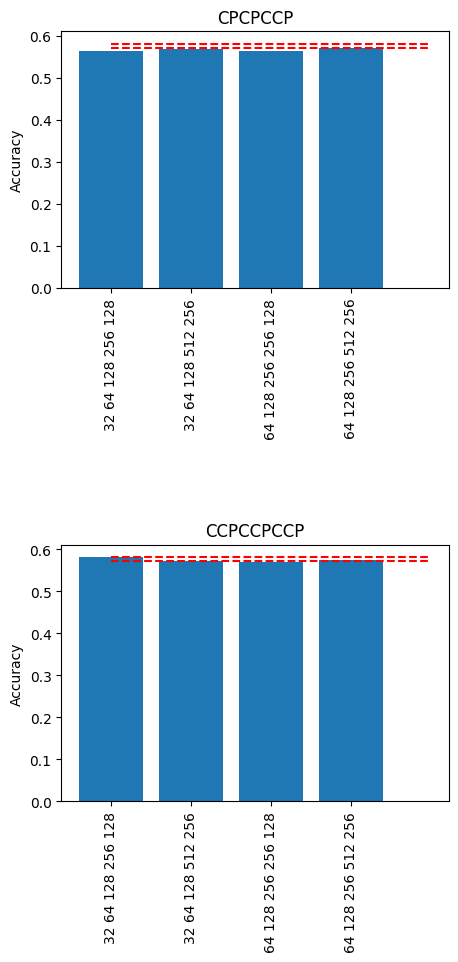

In [22]:
titles = ['CPCPCCP', 'CCPCCPCCP']
plots = [acc_model1, acc_model2]
best_model_acc = np.max(plots, axis=1)
labels = ['32 64 128 256 128', '32 64 128 512 256', '64 128 256 256 128', '64 128 256 512 256']

fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=1)

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.bar(labels, plot)
    ax.hlines(best_model_acc, 0, 4, 'r', '--')
    ax.set_xticklabels(labels, rotation = 90)
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

plt.show()